In [ ]:
# !pip install datasets
!pip install tokenizers
# !pip install transformers

!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=d8dd30235d15de17e539ab615763ea44b4ea134a2c609493982c2053ab411995
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig, DataCollatorForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import datasets
from datasets import load_dataset,Dataset,DatasetDict,ClassLabel,Sequence

# Load HuggingFace dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "vi")

In [ ]:
dataset["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
type(dataset["train"].features["ner_tags"])

datasets.features.features.Sequence

In [ ]:
label_names = dataset["train"].features["ner_tags"].feature.names

In [ ]:
dataset["train"][0]

{'tokens': ['Đồng', 'bằng', 'sông', 'Cửu', 'Long'],
 'ner_tags': [5, 6, 6, 6, 6],
 'langs': ['vi', 'vi', 'vi', 'vi', 'vi'],
 'spans': ['LOC: Đồng bằng sông Cửu Long']}

In [ ]:
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

# Load and process custom dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/total (2).csv')

In [ ]:
df = df[df["comparative"] == 1]

In [ ]:
# df.reset_index(drop=True, inplace=True)

In [ ]:
df

,Unnamed: 0,content,comparative,subject,object,aspect,predicate,label,NER
1,1,"iPhone 14 được ra mắt vào 09 / 2022 , được đán...",1,"['iPhone_14', 'iPhone_14']","['thế_hệ_trước', 'thế_hệ_trước']","['phần_cứng', 'phần_mềm']","['nâng_cấp_nhẹ', 'nâng_cấp_nhẹ']","[6, 6]","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,Về ngoại hình thì cũng có rất ít sự khác biệt ...,1,[''],['thế_hệ_tiền_nhiệm'],['ngoại_hình'],['rất_ít_sự_khác_biệt'],[2],"[0, 5, 6, 0, 0, 0, 7, 8, 8, 8, 8, 0, 0, 3, 4, ..."
12,12,"Nhìn chung , về thiết kế của iPhone 14 thì khô...",1,['iPhone_14'],['iPhone_13'],['thiết_kế'],['không_có_sự_khác_biệt_gì_quá_nhiều'],[2],"[0, 0, 0, 0, 5, 6, 0, 1, 2, 0, 7, 8, 8, 8, 8, ..."
16,16,"Tương tự , thì hệ thống camera vẫn giữ nguyên ...",1,['hệ_thống_camera'],[''],['thiết_kế'],['giữ_nguyên'],[2],"[0, 0, 0, 0, 1, 2, 2, 0, 7, 8, 5, 6, 0, 0, 0, ..."
19,19,"So với iPhone 13 , thì rất khó để nhận ra sự k...",1,"['2_thế_hệ_này', '2_thế_hệ_này']","['2_thế_hệ_này', '2_thế_hệ_này']","['vẻ_bề_ngoài', 'những_phần_mềm_bên_trong']","['khó_để_nhận_ra_sự_khác_biệt', 'không_có_quá_...","[2, 2]","[0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, ..."
...,...,...,...,...,...,...,...,...,...
4147,4147,iPhone 14 Pro Max và model Google Pixel 7 Pro...,1,['iPhone_14_Pro_Max'],['Google_Pixel_7_Pro'],[''],['đều_là_những_điện_thoại_tốt_nhất_hiệ...,[2],"[1, 2, 2, 2, 0, 0, 3, 4, 4, 4, 7, 8, 8, 8, 8, ..."
4148,4148,Mặc dù cả hai thiết bị đều sở hữu viên...,1,"['hai_thiết_bị', 'hai_thiết_bị']","['hai_thiết_bị', 'hai_thiết_bị']","['viên_pin_có_dung_lượng_tương_đương', 'tuổ...","['đều_sở_hữu', 'có_sự_chênh_lệch_khá_lơ...","[2, 1]","[0, 0, 0, 3, 4, 4, 7, 8, 8, 5, 6, 6, 6, 6, 6, ..."
4159,4159,"Tuy nhiên , sau hai giờ sử dụng thì điện ...",1,['iPhone'],[''],['kết_quả'],['tốt_hơn'],[6],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 6, ..."
4163,4163,iPhone 14 Pro Max có thời lượng pin tốt hơ...,1,['iPhone_14_Pro_Max'],['đối_thủ'],['thời_lượng_pin'],['tốt_hơn'],[6],"[1, 2, 2, 2, 0, 5, 6, 6, 7, 8, 0, 0, 3, 4]"


In [ ]:
import ast

# Function to process the label column
def process_label(label):
    # Use ast.literal_eval to safely evaluate the content inside the brackets
    try:
        label_list = ast.literal_eval(label)
        if isinstance(label_list, list):
            if len(label_list) == 0:
                return [0]
            return label_list
    except (SyntaxError, ValueError):
        pass
    return [0]

In [ ]:
df['content'] = df['content'].str.replace(r"[\[\]']", '', regex=True)

In [ ]:
df['content'] = df['content'].apply(lambda x: x.split(" "))

In [ ]:
df

,Unnamed: 0,content,comparative,subject,object,aspect,predicate,label,NER
1,1,"[iPhone, 14, được, ra, mắt, vào, 09, /, 2022, ...",1,"['iPhone_14', 'iPhone_14']","['thế_hệ_trước', 'thế_hệ_trước']","['phần_cứng', 'phần_mềm']","['nâng_cấp_nhẹ', 'nâng_cấp_nhẹ']","[6, 6]","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[Về, ngoại, hình, thì, cũng, có, rất, ít, sự, ...",1,[''],['thế_hệ_tiền_nhiệm'],['ngoại_hình'],['rất_ít_sự_khác_biệt'],[2],"[0, 5, 6, 0, 0, 0, 7, 8, 8, 8, 8, 0, 0, 3, 4, ..."
12,12,"[Nhìn, chung, ,, về, thiết, kế, của, iPhone, 1...",1,['iPhone_14'],['iPhone_13'],['thiết_kế'],['không_có_sự_khác_biệt_gì_quá_nhiều'],[2],"[0, 0, 0, 0, 5, 6, 0, 1, 2, 0, 7, 8, 8, 8, 8, ..."
16,16,"[Tương, tự, ,, thì, hệ, thống, camera, vẫn, gi...",1,['hệ_thống_camera'],[''],['thiết_kế'],['giữ_nguyên'],[2],"[0, 0, 0, 0, 1, 2, 2, 0, 7, 8, 5, 6, 0, 0, 0, ..."
19,19,"[So, với, iPhone, 13, ,, thì, rất, khó, để, nh...",1,"['2_thế_hệ_này', '2_thế_hệ_này']","['2_thế_hệ_này', '2_thế_hệ_này']","['vẻ_bề_ngoài', 'những_phần_mềm_bên_trong']","['khó_để_nhận_ra_sự_khác_biệt', 'không_có_quá_...","[2, 2]","[0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, ..."
...,...,...,...,...,...,...,...,...,...
4147,4147,"[iPhone, 14, Pro, Max, và, model, Google, Pix...",1,['iPhone_14_Pro_Max'],['Google_Pixel_7_Pro'],[''],['đều_là_những_điện_thoại_tốt_nhất_hiệ...,[2],"[1, 2, 2, 2, 0, 0, 3, 4, 4, 4, 7, 8, 8, 8, 8, ..."
4148,4148,"[Mặc, dù, cả, hai, thiết, bị, đều, sở, ...",1,"['hai_thiết_bị', 'hai_thiết_bị']","['hai_thiết_bị', 'hai_thiết_bị']","['viên_pin_có_dung_lượng_tương_đương', 'tuổ...","['đều_sở_hữu', 'có_sự_chênh_lệch_khá_lơ...","[2, 1]","[0, 0, 0, 3, 4, 4, 7, 8, 8, 5, 6, 6, 6, 6, 6, ..."
4159,4159,"[Tuy, nhiên, ,, sau, hai, giờ, sử, dụng, th...",1,['iPhone'],[''],['kết_quả'],['tốt_hơn'],[6],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 6, ..."
4163,4163,"[iPhone, 14, Pro, Max, có, thời, lượng, pin...",1,['iPhone_14_Pro_Max'],['đối_thủ'],['thời_lượng_pin'],['tốt_hơn'],[6],"[1, 2, 2, 2, 0, 5, 6, 6, 7, 8, 0, 0, 3, 4]"


In [ ]:
# Apply the process_label function to each row in the label column
df['NER'] = df['NER'].apply(lambda x: x.replace("[[", "["))
df['NER'] = df['NER'].apply(lambda x: x.replace("]]", "]"))
df['NER'] = df['NER'].apply(process_label)


# Explode the label lists into separate rows
# df = df.explode('label', ignore_index=True)
# df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df['NER']

1       [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 5, 6, 0, 0, 0, 7, 8, 8, 8, 8, 0, 0, 3, 4, ...
12      [0, 0, 0, 0, 5, 6, 0, 1, 2, 0, 7, 8, 8, 8, 8, ...
16      [0, 0, 0, 0, 1, 2, 2, 0, 7, 8, 5, 6, 0, 0, 0, ...
19      [0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, ...
                              ...                        
4147    [1, 2, 2, 2, 0, 0, 3, 4, 4, 4, 7, 8, 8, 8, 8, ...
4148    [0, 0, 0, 3, 4, 4, 7, 8, 8, 5, 6, 6, 6, 6, 6, ...
4159    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 6, ...
4163           [1, 2, 2, 2, 0, 5, 6, 6, 7, 8, 0, 0, 3, 4]
4169    [0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 5, ...
Name: NER, Length: 812, dtype: object

In [ ]:
df['content'][1]

['iPhone',
 '14',
 'được',
 'ra',
 'mắt',
 'vào',
 '09',
 '/',
 '2022',
 ',',
 'được',
 'đánh',
 'giá',
 'là',
 'chỉ',
 'nâng',
 'cấp',
 'nhẹ',
 'về',
 'phần',
 'cứng',
 'cũng',
 'như',
 'phần',
 'mềm',
 'so',
 'với',
 'thế',
 'hệ',
 'trước',
 '.']

In [ ]:
df.rename(columns = {'content': 'tokens', 'NER':'ner_tags'}, inplace = True)

In [ ]:
df = df.drop(['Unnamed: 0', 'comparative', 'object', 'aspect', 'subject', 'predicate', 'label'], axis=1)

In [ ]:
len(df)

812

In [ ]:
# number_of_errors = 0
# error_indices = []
# for i in range(1, len(df)):  # Change the loop range
#   len_of_token = len(df["tokens"][i])
#   len_of_ner = len(df["ner_tags"][i])
#   if len_of_token != len_of_ner:
#     number_of_errors += 1
#     error_indices.append(i)  # Store the error indices in a list
#     print(i)
#     print(len_of_token)
#     print(len_of_ner)
#     print("\n")
# print("Number of errors: " + str(number_of_errors))

KeyError: ignored

In [ ]:
# df.drop(error_indices, inplace=True)

In [ ]:
df

,tokens,ner_tags
1,"[iPhone, 14, được, ra, mắt, vào, 09, /, 2022, ...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Về, ngoại, hình, thì, cũng, có, rất, ít, sự, ...","[0, 5, 6, 0, 0, 0, 7, 8, 8, 8, 8, 0, 0, 3, 4, ..."
12,"[Nhìn, chung, ,, về, thiết, kế, của, iPhone, 1...","[0, 0, 0, 0, 5, 6, 0, 1, 2, 0, 7, 8, 8, 8, 8, ..."
16,"[Tương, tự, ,, thì, hệ, thống, camera, vẫn, gi...","[0, 0, 0, 0, 1, 2, 2, 0, 7, 8, 5, 6, 0, 0, 0, ..."
19,"[So, với, iPhone, 13, ,, thì, rất, khó, để, nh...","[0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8, 0, ..."
...,...,...
4147,"[iPhone, 14, Pro, Max, và, model, Google, Pix...","[1, 2, 2, 2, 0, 0, 3, 4, 4, 4, 7, 8, 8, 8, 8, ..."
4148,"[Mặc, dù, cả, hai, thiết, bị, đều, sở, ...","[0, 0, 0, 3, 4, 4, 7, 8, 8, 5, 6, 6, 6, 6, 6, ..."
4159,"[Tuy, nhiên, ,, sau, hai, giờ, sử, dụng, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 5, 6, ..."
4163,"[iPhone, 14, Pro, Max, có, thời, lượng, pin...","[1, 2, 2, 2, 0, 5, 6, 6, 7, 8, 0, 0, 3, 4]"


In [ ]:
data = Dataset.from_pandas(df)

In [ ]:
data.features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
class_label = ["O", "B-Subject", "I-Subject", "B-Object", "I-Object", "B-Aspect", "I-Aspect", "B-Predicate", "I-Predicate"]
data = data.cast_column("ner_tags", datasets.Sequence(datasets.ClassLabel(names=class_label)))

Casting the dataset:   0%|          | 0/812 [00:00<?, ? examples/s]

In [ ]:
data.features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Subject', 'I-Subject', 'B-Object', 'I-Object', 'B-Aspect', 'I-Aspect', 'B-Predicate', 'I-Predicate'], id=None), length=-1, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
train_testvalid = data.train_test_split(test_size=0.2,seed=15)

# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

In [ ]:
dataset["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Subject', 'I-Subject', 'B-Object', 'I-Object', 'B-Aspect', 'I-Aspect', 'B-Predicate', 'I-Predicate'], id=None), length=-1, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
len(dataset["train"]["tokens"])

609

In [ ]:
len(dataset["train"]["ner_tags"])

609

In [ ]:
# number_of_errors = 0
# for i in range(len(dataset["train"]["tokens"])):
#   len_of_token = len(dataset["train"]["tokens"][i])
#   len_of_ner = len(dataset["train"]["ner_tags"][i])
#   if len_of_token != len_of_ner:
#     number_of_errors += 1
#     print(i)
#     print(len_of_token)
#     print(len_of_ner)
#     print("\n")
# print("Number of errors: " + str(number_of_errors))

KeyboardInterrupt: ignored

In [ ]:
len(dataset)

3

In [ ]:
label_names = dataset["train"].features["ner_tags"].feature.names

In [ ]:
label_names

['O',
 'B-Subject',
 'I-Subject',
 'B-Object',
 'I-Object',
 'B-Aspect',
 'I-Aspect',
 'B-Predicate',
 'I-Predicate']

# Huggingface preprocessing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased", use_fast = True)

#Get the values for input_ids, token_type_ids, attention_mask
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True)
  #tokenized_samples is not a datasets object so this alone won't work with Trainer API, hence map is used
  #so the new keys [input_ids, labels (after adjustment)]
  #can be added to the datasets dict for each train test validation split
  total_adjusted_labels = []
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []

    for wid in word_ids_list:
      if(wid is None):
        adjusted_label_ids.append(-100)
      elif(wid!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = wid
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])

    total_adjusted_labels.append(adjusted_label_ids)
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True)

Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset["train"][0]

{'tokens': ['Tuy',
  'nhiên',
  ',',
  'iPhone',
  '11',
  'Pro',
  'và',
  'iPhone',
  '11',
  'Pro',
  'Max',
  'sẽ',
  'có',
  'kích',
  'thước',
  'lớn',
  'hơn',
  'so',
  'với',
  'các',
  'dòng',
  'điện',
  'thoại',
  'khác',
  '.'],
 'ner_tags': [0,
  0,
  0,
  1,
  2,
  2,
  0,
  1,
  2,
  2,
  2,
  0,
  0,
  5,
  6,
  7,
  8,
  0,
  0,
  3,
  4,
  4,
  4,
  4,
  0],
 '__index_level_0__': 405,
 'input_ids': [101,
  24903,
  17685,
  117,
  37167,
  10193,
  14021,
  10432,
  37167,
  10193,
  14021,
  12854,
  16807,
  10601,
  28901,
  92066,
  15731,
  14789,
  10380,
  11182,
  10792,
  40563,
  23087,
  74603,
  14393,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  0,
  0,
  0,
  1

In [ ]:
tokenized_dataset["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Subject', 'I-Subject', 'B-Object', 'I-Object', 'B-Aspect', 'I-Aspect', 'B-Predicate', 'I-Predicate'], id=None), length=-1, id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_metric

In [ ]:
metric = load_metric("seqeval")

<ipython-input-23-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    for k in results.keys():
      if(k not in flattened_results.keys()):
        flattened_results[k+"_f1"]=results[k]["f1"]

    return flattened_results

In [ ]:
len(label_names)

9

In [ ]:
id2label = {0: "O", 1: "B-Subject", 2: "I-Subject", 3: "B-Object", 4: "I-Object", 5: "B-Aspect", 6: "B-Aspect",
            7: "B-Predicate", 8: "I-Predicate"}

label2id = {"O": 0 , "B-Subject": 1, "I-Subject": 2 , "B-Object": 3, "I-Object": 4, "B-Aspect": 5, "B-Aspect": 6,
            "B-Predicate": 7, "I-Predicate": 8}

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(label_names), id2label=id2label, label2id=label2id)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [ ]:
for name, module in model.named_modules():
  print(name)


roberta
roberta.embeddings
roberta.embeddings.word_embeddings
roberta.embeddings.position_embeddings
roberta.embeddings.token_type_embeddings
roberta.embeddings.LayerNorm
roberta.embeddings.dropout
roberta.encoder
roberta.encoder.layer
roberta.encoder.layer.0
roberta.encoder.layer.0.attention
roberta.encoder.layer.0.attention.self
roberta.encoder.layer.0.attention.self.query
roberta.encoder.layer.0.attention.self.key
roberta.encoder.layer.0.attention.self.value
roberta.encoder.layer.0.attention.self.dropout
roberta.encoder.layer.0.attention.output
roberta.encoder.layer.0.attention.output.dense
roberta.encoder.layer.0.attention.output.LayerNorm
roberta.encoder.layer.0.attention.output.dropout
roberta.encoder.layer.0.intermediate
roberta.encoder.layer.0.intermediate.dense
roberta.encoder.layer.0.intermediate.intermediate_act_fn
roberta.encoder.layer.0.output
roberta.encoder.layer.0.output.dense
roberta.encoder.layer.0.output.LayerNorm
roberta.encoder.layer.0.output.dropout
roberta.encod

In [ ]:
for name, module in model.named_modules():
  freeze_list = [".embeddings", ".layer.0.", ".layer.1.", ".layer.2.", ".layer.3."]
  for layer in freeze_list:
    if layer in name:
      for param in module.parameters():
        param.requires_grad = False

In [ ]:
for name, module in model.named_modules():
    for param in module.parameters():
        if param.requires_grad == True:
          print(name)
          break


roberta
roberta.encoder
roberta.encoder.layer
roberta.encoder.layer.4
roberta.encoder.layer.4.attention
roberta.encoder.layer.4.attention.self
roberta.encoder.layer.4.attention.self.query
roberta.encoder.layer.4.attention.self.key
roberta.encoder.layer.4.attention.self.value
roberta.encoder.layer.4.attention.output
roberta.encoder.layer.4.attention.output.dense
roberta.encoder.layer.4.attention.output.LayerNorm
roberta.encoder.layer.4.intermediate
roberta.encoder.layer.4.intermediate.dense
roberta.encoder.layer.4.output
roberta.encoder.layer.4.output.dense
roberta.encoder.layer.4.output.LayerNorm
roberta.encoder.layer.5
roberta.encoder.layer.5.attention
roberta.encoder.layer.5.attention.self
roberta.encoder.layer.5.attention.self.query
roberta.encoder.layer.5.attention.self.key
roberta.encoder.layer.5.attention.self.value
roberta.encoder.layer.5.attention.output
roberta.encoder.layer.5.attention.output.dense
roberta.encoder.layer.5.attention.output.LayerNorm
roberta.encoder.layer.5.in

In [ ]:
batch_size = 128
training_args = TrainingArguments(
output_dir="results",
num_train_epochs=100,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=len(tokenized_dataset['train']) // batch_size)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Aspect F1,Object F1,Predicate F1,Subject F1
1,1.763800,1.467013,0.216981,0.056511,0.089669,0.501569,0.000000,0.000000,0.023392,0.269231
2,1.351700,1.134253,0.281796,0.277641,0.279703,0.619608,0.218045,0.243902,0.294118,0.375691
3,1.024000,0.951610,0.371212,0.361179,0.366127,0.667059,0.346774,0.333333,0.392157,0.380952
4,0.930000,0.898377,0.365044,0.405405,0.384168,0.690588,0.379845,0.437500,0.378571,0.362694
5,0.594400,0.897393,0.389522,0.420147,0.404255,0.701961,0.378788,0.461538,0.417582,0.379888
6,0.483900,0.854372,0.410019,0.542998,0.467230,0.724706,0.464164,0.424658,0.491694,0.466019
7,0.417700,0.908597,0.464876,0.552826,0.505051,0.731765,0.459930,0.515625,0.519298,0.544503
8,0.339400,0.954517,0.451362,0.570025,0.503800,0.731765,0.513410,0.465409,0.496732,0.533333
9,0.348800,0.902009,0.480808,0.584767,0.527716,0.745098,0.460481,0.536232,0.569343,0.562814
10,0.210900,1.033040,0.500000,0.624079,0.555191,0.745490,0.525926,0.581560,0.546053,0.590000


dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])
dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'ov

TrainOutput(global_step=600, training_loss=0.08802277146528165, metrics={'train_runtime': 939.289, 'train_samples_per_second': 69.095, 'train_steps_per_second': 0.639, 'total_flos': 2882613797980578.0, 'train_loss': 0.08802277146528165, 'epoch': 100.0})

In [ ]:
model.num_parameters(only_trainable = False)

134414601

In [ ]:
trainer.save_model("/content/drive/MyDrive/VLSP23/Data/HH/baseline_models/multi_100_epoch")

In [ ]:
import matplotlib.pyplot as plt

loss_list = []
val_loss_list = []
for i in range(0, len(trainer.state.log_history)):
  if "eval_loss" in trainer.state.log_history[i].keys():
    val_loss_list.append(trainer.state.log_history[i]["eval_loss"])
  if "loss" in trainer.state.log_history[i].keys():
    loss_list.append(trainer.state.log_history[i]["loss"])
  if "eval_loss" in trainer.state.log_history[i].keys() and "loss" in trainer.state.log_history[i].keys():
    print(trainer.state.log_history[i])

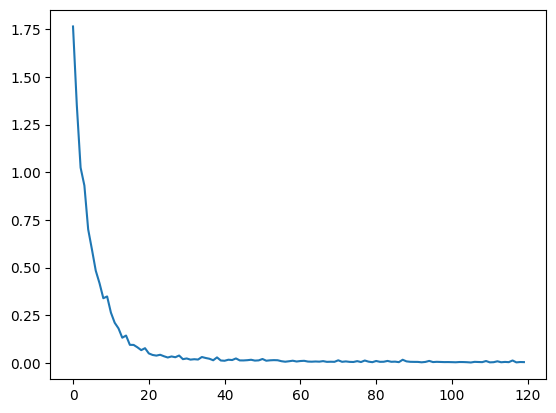

In [ ]:
plt.plot(loss_list)

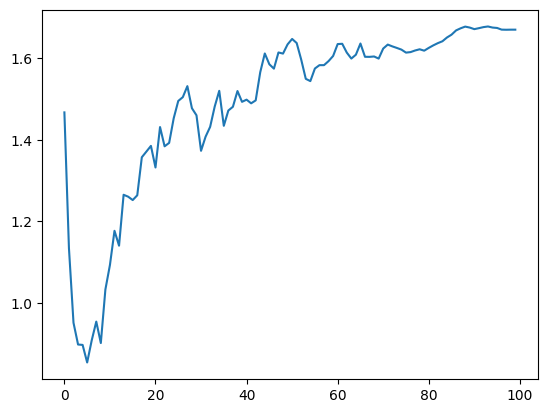

In [ ]:
plt.plot(val_loss_list)

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])

predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)

true_predictions = [

[label_names[p] for (p, l) in zip(prediction, label) if l != -100]

for prediction, label in zip(predictions, labels)

]

true_labels = [

[label_names[l] for (p, l) in zip(prediction, label) if l != -100]

for prediction, label in zip(predictions, labels)

]

results = metric.compute(predictions=true_predictions, references=true_labels)

results

dict_keys(['Aspect', 'Object', 'Predicate', 'Subject', 'overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy'])


{'Aspect': {'precision': 0.4397163120567376,
  'recall': 0.6019417475728155,
  'f1': 0.5081967213114754,
  'number': 103},
 'Object': {'precision': 0.47368421052631576,
  'recall': 0.5373134328358209,
  'f1': 0.5034965034965035,
  'number': 67},
 'Predicate': {'precision': 0.5076923076923077,
  'recall': 0.6055045871559633,
  'f1': 0.5523012552301256,
  'number': 109},
 'Subject': {'precision': 0.5116279069767442,
  'recall': 0.4888888888888889,
  'f1': 0.5,
  'number': 90},
 'overall_precision': 0.48036951501154734,
 'overall_recall': 0.5636856368563685,
 'overall_f1': 0.518703241895262,
 'overall_accuracy': 0.781706379707917}

In [ ]:
from transformers import pipeline

model_test = AutoModelForTokenClassification.from_pretrained("/content/transformers/test_phobert_ner")
nlp = pipeline("token-classification", model=model_test, tokenizer=tokenizer)
example = "Cả hai đều sử dụng công nghệ tấm nên OLED mới nhất của Samsung."
ner_results = nlp(example)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
ner_results

[{'entity': 'LABEL_3',
  'score': 0.85116845,
  'index': 1,
  'word': 'Ca',
  'start': 0,
  'end': 2},
 {'entity': 'LABEL_3',
  'score': 0.8590955,
  'index': 2,
  'word': '̉</w>',
  'start': 2,
  'end': 3},
 {'entity': 'LABEL_4',
  'score': 0.9209589,
  'index': 3,
  'word': 'hai</w>',
  'start': 4,
  'end': 7},
 {'entity': 'LABEL_7',
  'score': 0.9401267,
  'index': 4,
  'word': 'đê',
  'start': 8,
  'end': 10},
 {'entity': 'LABEL_7',
  'score': 0.93959916,
  'index': 5,
  'word': '̀',
  'start': 10,
  'end': 11},
 {'entity': 'LABEL_7',
  'score': 0.9405583,
  'index': 6,
  'word': 'u</w>',
  'start': 11,
  'end': 12},
 {'entity': 'LABEL_8',
  'score': 0.94702476,
  'index': 7,
  'word': 'sư',
  'start': 13,
  'end': 15},
 {'entity': 'LABEL_8',
  'score': 0.9470121,
  'index': 8,
  'word': '̉</w>',
  'start': 15,
  'end': 16},
 {'entity': 'LABEL_8',
  'score': 0.946349,
  'index': 9,
  'word': 'du',
  'start': 17,
  'end': 19},
 {'entity': 'LABEL_8',
  'score': 0.9466644,
  'index': 